<a href="https://colab.research.google.com/github/shiva7579/Machine_learning/blob/main/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,InputLayer,BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

**Dataset**

In [ ]:
dataset,dataset_info=tfds.load("malaria",with_info=True,as_supervised=True,shuffle_files=True,split=['train'])
dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete0I4QT2/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


[<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

**Splitting Dataset**

In [ ]:
def splits(dataset,train_ratio,val_ratio,test_ratio):
  dataset_size=len(dataset)

  train_dataset= dataset.take(int(train_ratio*dataset_size))

  val_test_dataset=dataset.skip(int(train_ratio*dataset_size))
  val_dataset=val_test_dataset.take(int(val_ratio*dataset_size))

  test_dataset=val_test_dataset.skip(int(val_ratio*dataset_size))

  return train_dataset,val_dataset,test_dataset




In [ ]:
train_ratio=0.8
val_ratio=0.1
test_ratio=0.1

#dataset=tf.data.Dataset.range(10)
#list(dataset.as_numpy_iterator())

train_dataset,val_dataset,test_dataset=splits(dataset[0],train_ratio,val_ratio,test_ratio)
#print(list(train_dataset.take(1).as_numpy_iterator()))

In [ ]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmpi2glydfbtfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

**Data Visualization**

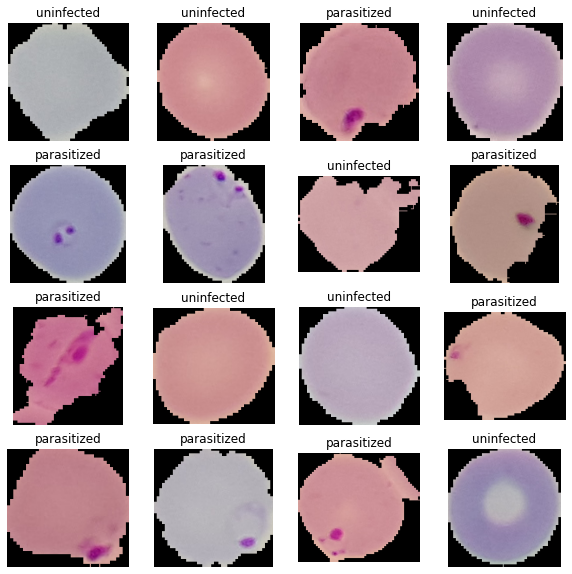

In [ ]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(16)):
  plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')




**Data Processing**

In [ ]:
I_m_size=224
def resize_rescale(image,label):
  return tf.image.resize(image,(I_m_size,I_m_size))/255.0,label

In [ ]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)
print(train_dataset)
print(val_dataset)
print(test_dataset)

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


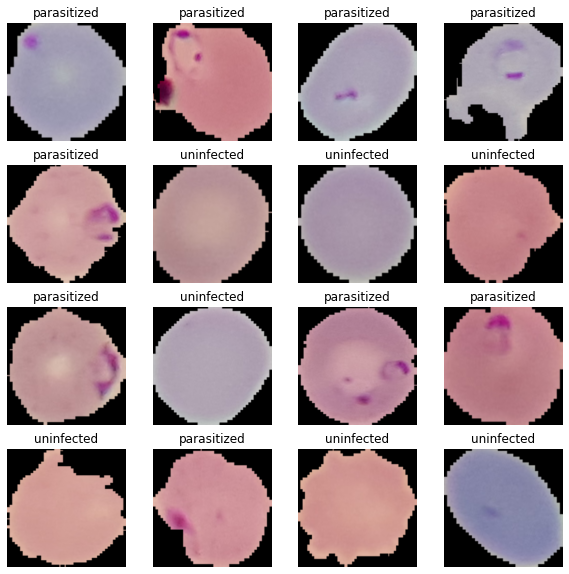

In [ ]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(16)):
  plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')


In [ ]:
BATCH_SIZE=32
train_dataset=train_dataset.shuffle(8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(1)


Model: Lenet Model

In [ ]:
model=Sequential([
                  InputLayer(input_shape=(I_m_size,I_m_size,3)),

                  tf.keras.layers.Conv2D(filters=6,kernel_size=(5,5),strides=1,padding='valid',activation='relu'),
                  BatchNormalization(),
                  tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

                  tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),strides=1,padding='valid',activation='relu'),
                  BatchNormalization(),
                  tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

                  Flatten(),
                  Dense(units=120,activation='relu'),
                  BatchNormalization(),
                  Dense(units=84,activation='relu'),
                  BatchNormalization(),
                  Dense(units=1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 16)     64        
 hNormalization)                                                 
                                                        

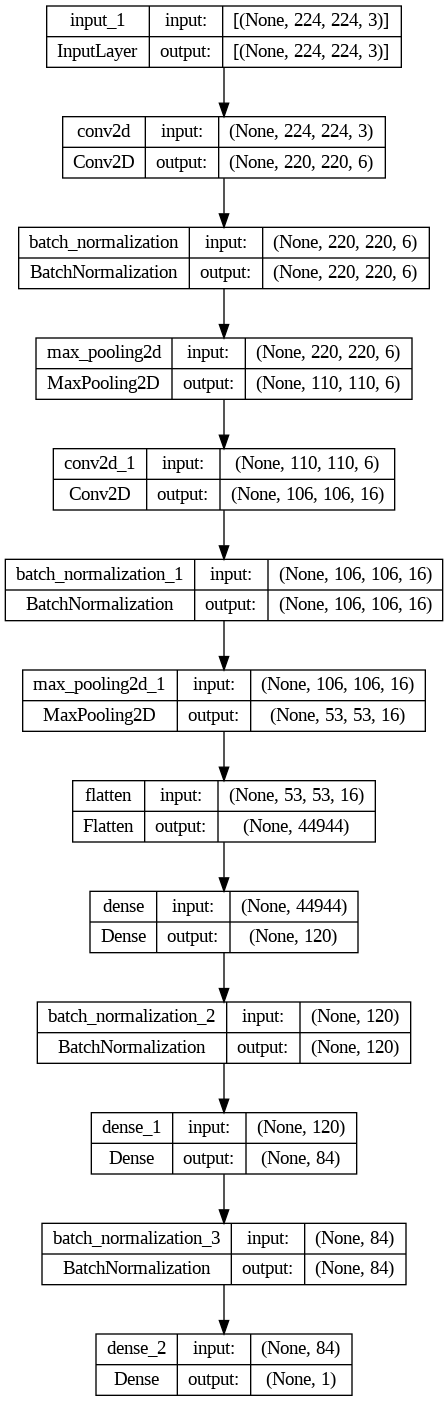

In [ ]:
tf.keras.utils.plot_model(model,to_file="model.png",show_shapes=True)

In [ ]:
model.compile (optimizer= Adam(learning_rate=0.01),
               loss= BinaryCrossentropy(),
               metrics=['Accuracy'])

In [ ]:
history=model.fit(train_dataset,epochs=30,validation_data=val_dataset,callbacks=EarlyStopping(patience=5,monitor='val_Accuracy'),verbose=2)

Epoch 1/30
689/689 - 65s - loss: 0.3657 - Accuracy: 0.8347 - val_loss: 0.8024 - val_Accuracy: 0.8377 - 65s/epoch - 95ms/step
Epoch 2/30
689/689 - 47s - loss: 0.1761 - Accuracy: 0.9444 - val_loss: 0.3192 - val_Accuracy: 0.9401 - 47s/epoch - 68ms/step
Epoch 3/30
689/689 - 46s - loss: 0.1621 - Accuracy: 0.9487 - val_loss: 0.2846 - val_Accuracy: 0.9434 - 46s/epoch - 67ms/step
Epoch 4/30
689/689 - 46s - loss: 0.1506 - Accuracy: 0.9512 - val_loss: 0.1746 - val_Accuracy: 0.9463 - 46s/epoch - 67ms/step
Epoch 5/30
689/689 - 49s - loss: 0.1418 - Accuracy: 0.9527 - val_loss: 0.3248 - val_Accuracy: 0.9365 - 49s/epoch - 71ms/step
Epoch 6/30
689/689 - 46s - loss: 0.1264 - Accuracy: 0.9593 - val_loss: 0.1599 - val_Accuracy: 0.9539 - 46s/epoch - 66ms/step


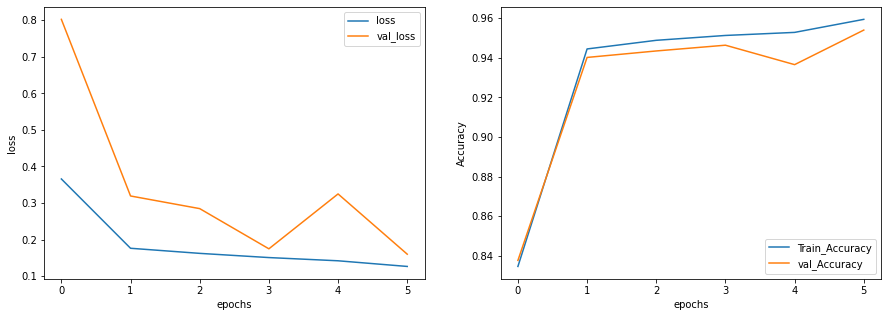

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss','val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['Train_Accuracy','val_Accuracy'])

**Evaluate Model**

In [ ]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 25s 5ms/step - loss: 0.1763 - Accuracy: 0.9449


[0.17630593478679657, 0.9448676109313965]

In [ ]:
model.predict(test_dataset.take(1))

1/1 [==============================] - 12s 12s/step


array([[0.90266323]], dtype=float32)

In [ ]:
def infected_or_not(x):
  if (x<0.5):
    return str('Infected')
  else :
   return str('Healthy')
infected_or_not(model.predict(test_dataset.take(1)))

1/1 [==============================] - 12s 12s/step


'Infected'

1/1 [==============================] - 0s 23ms/step


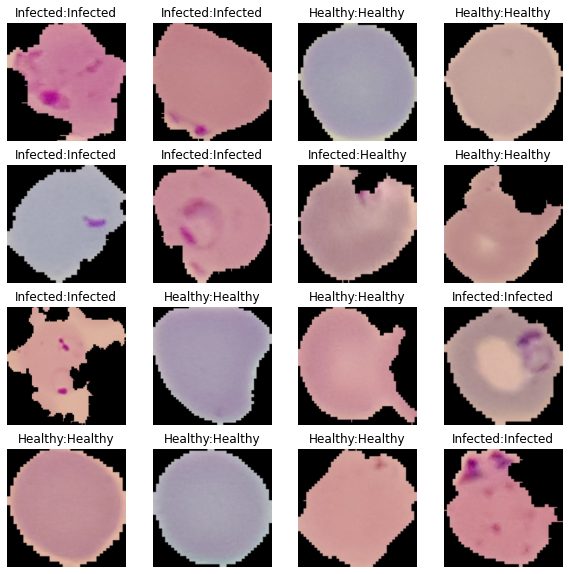

In [ ]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(test_dataset.take(16)):
  plt.subplot(4,4,i+1)
  plt.imshow(image[0])
  plt.title(str(infected_or_not(label.numpy()[0]))+':'+str(infected_or_not(model.predict(image)[0][0])))
  plt.axis('off')

**Loading And Saving**

In [ ]:
model.save('malaria_prediction_model')

In [ ]:
loaded_model=tf.keras.models.load_model('malaria_prediction_model')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 16)     64        
 hNormalization)                                                 
                                                        

In [ ]:
model.save_weights("weigths/malaria_prediction_model_weights")

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/malaria_prediction_model/ /content/drive/MyDrive/malaria_lenet/

In [ ]:
!cp -r /content/weigths/ /content/drive/MyDrive/malaria_lenet/